# STREAM DRAM Bandwidth for I/O-Die P-States and DRAM Frequencies, on AMD EPYC 7502

## Load necessary depencencies

In [1]:
import numpy
import csv
import re
import os
import matplotlib.pyplot as plt
import matplotlib
from pylab import rcParams

## Define functions

In [2]:
# taken from https://github.com/kuk/log-progress

# MIT License
#
# Copyright (c) 2016 bureaucratic-two-cores-per-CCX_4clabs
# 
# Permission is hereby granted, free of charge, to any person obtaining a copy
# of this software and associated documentation files (the "Software"), to deal
# in the Software without restriction, including without limitation the rights
# to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
# copies of the Software, and to permit persons to whom the Software is
# furnished to do so, subject to the following conditions:
#
# The above copyright notice and this permission notice shall be included in all
# copies or substantial portions of the Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
# AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
# OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
# SOFTWARE.

def log_progress(sequence, every=None, size=None, name='Items'):
    from ipywidgets import IntProgress, HTML, VBox
    from IPython.display import display

    is_iterator = False
    if size is None:
        try:
            size = len(sequence)
        except TypeError:
            is_iterator = True
    if size is not None:
        if every is None:
            if size <= 200:
                every = 1
            else:
                every = int(size / 200)     # every 0.5%
    else:
        assert every is not None, 'sequence is iterator, set every'

    if is_iterator:
        progress = IntProgress(min=0, max=1, value=1)
        progress.bar_style = 'info'
    else:
        progress = IntProgress(min=0, max=size, value=0)
    label = HTML()
    box = VBox(children=[label, progress])
    display(box)

    index = 0
    try:
        for index, record in enumerate(sequence, 1):
            if index == 1 or index % every == 0:
                if is_iterator:
                    label.value = '{name}: {index} / ?'.format(
                        name=name,
                        index=index
                    )
                else:
                    progress.value = index
                    label.value = u'{name}: {index} / {size}'.format(
                        name=name,
                        index=index,
                        size=size
                    )
            yield record
    except:
        progress.bar_style = 'danger'
        raise
    else:
        progress.bar_style = 'success'
        progress.value = index
        label.value = "{name}: {index}".format(
            name=name,
            index=str(index or '?')
        )

In [3]:
# calculate maxima and standard deviations from values in file list for all instructions in list
def evaluation(filelist, case, DRAM_freq, pstate, function):
    values = numpy.array([])
    maxima = numpy.array([])
    stdevs = numpy.array([])

    core_found = False
    data_found = False

    # iterate over lines in file
    for file in filelist:
        
        if case in file and DRAM_freq in file and "io-P"+pstate in file:
 
            for line in open(file):
                # check if file has data for function
                if line.startswith(function):
                    core_found = True

                    values = numpy.append(values, float(line.split()[1])/1000)


    # calculate median
    maxima = max(values)
    stdevs = numpy.std(values)

    return maxima, stdevs

In [23]:
# plotter function
def plotter(maxima, function, DRAM_freqs, pstates, corelist, machine):

    fig, ax = plt.subplots()
    im = ax.imshow(maxima, cmap='coolwarm')
    
    # set title
    #ax.set_title('STREAM ' + function + ' RAM Bandwidth in [GB/s], on ' + machine + '\n')
    
    DRAM_freqs = ["1.467", "1.6"]
    
    # setup for main axes
    xlabels = numpy.array(DRAM_freqs*len(corelist))
    
    ylabels = numpy.array(pstates)
   
    x = numpy.arange(len(xlabels))
    y = numpy.arange(len(ylabels))
    
    ax.set_xlabel('DRAM Frequency [GHz]')
    ax.set_ylabel('I/O-Die P-State')

    ax.set_xticks(x)
    ax.set_yticks(y)
    
    ax.set_xticklabels(xlabels, rotation=0, ha='center', rotation_mode='anchor') 
    ax.set_yticklabels(ylabels, rotation=0, ha='right', rotation_mode='anchor') 
    
    # create colorbar
    cbarlabel = 'Bandwidth [GB/s]'
    
    # define cbar ticks
    steps = 4
    
    cbarticks = []
    
    cbarticks.append(round(maxima.min()+0.05,1))
    cbarticks.append(round(maxima.max()-0.05,1))
    
    for i in range(1,steps):
        cbarticks.append(round(maxima.min() + ((maxima.max()-maxima.min()) * float(i)/steps),1))
        
    cbarticks.sort()

    #cbar = ax.figure.colorbar(im, shrink=0.61, pad=0.02, ticks=cbarticks)
    cbar = ax.figure.colorbar(im, shrink=0.935, pad=0.02, ticks=cbarticks)
    cbar.ax.set_ylabel(cbarlabel, rotation=+90, va="top")

    # secondary x-axis
    def cyctons(x):
        return (x-0.5) * len(DRAM_freqs)
    
    def nstocyc(x):
        return (x-0.5) / len(DRAM_freqs)
    
    # secondary x-axis
    secax = ax.secondary_xaxis('top', functions =(nstocyc, cyctons)) 
    secax.set_xticks(numpy.arange(len(pstates), step=1))
    secax.set_xticklabels(corelist)
    secax.set_xlabel('Cores on one CCD')
    
    lc = 'white'
    lw = 3
    ax.axvline(x=1.5, color=lc, linewidth=lw)
    ax.axvline(x=3.5, color=lc, linewidth=lw)
    ax.axvline(x=5.5, color=lc, linewidth=lw)
    ax.axvline(x=7.5, color=lc, linewidth=lw)

    # set color for font depending on value
    thresholdLower = im.norm(maxima.max())/3.
    thresholdUpper = im.norm(maxima.max())/1.2
   
    textcolors=("white", "black")
    
    # Loop over data dimensions and create text annotations.
    for j in range(len(xlabels)):
        for i in range(len(ylabels)):
            if maxima[i, j] > 100:
                value = round(maxima[i, j])
            else:
                value = round(maxima[i, j], 1)

            text = ax.text(j, i, value,
                           ha="center", va="center", 
                           #size="small",
                           color=textcolors[int(im.norm(maxima[i, j]) > 
                                                thresholdLower and im.norm(maxima[i, j]) < 
                                                thresholdUpper)]) 
    
    # ensure proper layout
    fig.tight_layout()
        
    # save plot to file
    filename = machine + '-STREAM-' + function  + '-all-p_states.pdf'
    
    matplotlib.pyplot.savefig(filename, dpi=300, format='pdf', bbox_inches = 'tight', pad_inches = 0) 
    print(filename + ' has been saved to disk.')


In [5]:
# generate lists of files with files according to search parameters
def listgenerator (filelist, cores, stride, retlist):
    
    for file in filelist:
        if stride == 1:
            string = "all-cores-per-CCX_" + str(cores) + "c"
        elif stride == 2:
            string = "two-cores-per-CCX_" + str(cores) + "c"
      
        if string in file:
            retlist.append(file) 
            break

## Create file lists

In [6]:
# get list of all files in directory

filelist = []

pstates = ['auto', '0', '1', '2', '3']
DRAM_freqs = ["1467", "1600"]

for pstate in log_progress(pstates):
    for DRAM_freq in DRAM_freqs:
        path = 'io-P' + str(pstate) + '/DRAM-' + DRAM_freq + "MHz/intel-AMD/"

        for entry in os.scandir(path): 
            filelist.append(entry.path)

print("Total number of files: " + str(len(filelist)))

Widget Javascript not detected.  It may not be installed or enabled properly.


Total number of files: 100


## Process data

In [7]:
functions = ['Copy', 'Scale', 'Add', 'Triad']
pstates = ['auto', '0', '1', '2', '3']


cases = ["all-cores-per-CCX_1c", "all-cores-per-CCX_2c", "all-cores-per-CCX_3c",
        "all-cores-per-CCX_4c", "two-cores-per-CCX_4c"]
pstates.reverse()

maxima = numpy.zeros([len(functions), len(pstates), len(DRAM_freqs) * len(cases)])
stdevs = numpy.zeros([len(functions), len(pstates), len(DRAM_freqs) * len(cases)])


for function in log_progress(functions):
    function_index = functions.index(function)
    
    for pstate in pstates:
        pstate_index = pstates.index(pstate)
    
        for case in cases:
            case_index = cases.index(case)

            for DRAM_freq in DRAM_freqs:
                DRAM_freq_index = DRAM_freqs.index(DRAM_freq)

                maxima[function_index][pstate_index][case_index * len(DRAM_freqs) + DRAM_freq_index], \
                stdevs[function_index][pstate_index][case_index * len(DRAM_freqs) + DRAM_freq_index] = \
                evaluation(filelist, case, DRAM_freq, pstate, function)
        

Widget Javascript not detected.  It may not be installed or enabled properly.


## Plot data

Widget Javascript not detected.  It may not be installed or enabled properly.


../../../paper/fig/AMD EPYC 7502-STREAM-Copy-all-p_states.pdf has been saved to disk.
../../../paper/fig/AMD EPYC 7502-STREAM-Scale-all-p_states.pdf has been saved to disk.
../../../paper/fig/AMD EPYC 7502-STREAM-Add-all-p_states.pdf has been saved to disk.
../../../paper/fig/AMD EPYC 7502-STREAM-Triad-all-p_states.pdf has been saved to disk.


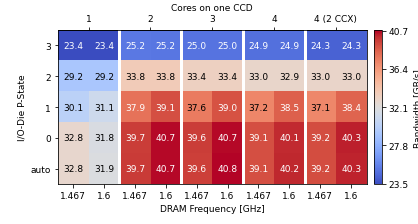

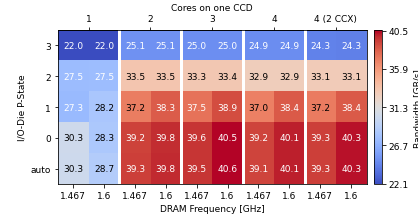

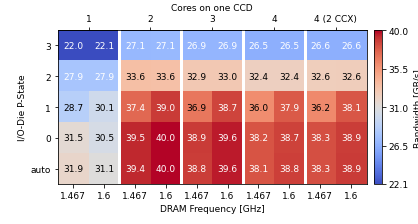

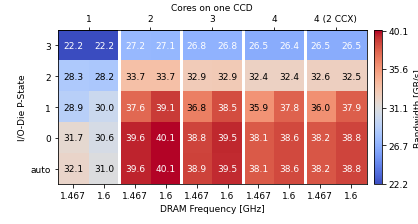

In [24]:
rcParams['figure.figsize'] = 6, 3
rcParams['font.size'] = 9

corelist = ["1", "2", "3", "4", "4 (2 CCX)"]
#corelist.reverse()

for function in log_progress(functions):
    function_index = functions.index(function)
    
    plotter(maxima[function_index], function, DRAM_freqs, pstates, corelist, 'AMD EPYC 7502')